In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping


## Data Loading

In [2]:
x_train=np.load('../BraiNeoCare/Datasets/balanced_x_train_common_4s.npy', mmap_mode='r')[0:10000,...]
x_test=np.load('../BraiNeoCare/Datasets/balanced_x_test_common_4s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare/Datasets/balanced_y_train_common_4s.npy', mmap_mode='r')[0:10000,...]
y_test=np.load('../BraiNeoCare/Datasets/balanced_y_test_common_4s.npy', mmap_mode='r')


In [5]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],1024,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],1024,12)
y_test = y_test[test_indices]

In [6]:
x_train=x_train*(10**5)
x_test=x_test*(10**5)

## Tiny model

In [28]:
'''For 4s partitions I used dropout=0.5, and learning rate=0.001, and weight decay=0.0001. Saved model is model1_for_4s.keras was taken
after 125 epoch with batch size=64'''

'''For 1s partitions I used dropout=0.2, and used just 'adam'. Saved model is model1_for_1s.keras was taken
after 125 epoch with batch size=128'''

Input=keras.Input(shape=(256,12),name="Input_signal")
x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
a=layers.add([x,y])
x=layers.MaxPooling1D(4)(a)
x=layers.Conv1D(64,3,padding="same",activation='swish')(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dense(16,activation='swish')(x)
x=layers.Dropout(0.2)(x)  
x=layers.Dense(1,activation='sigmoid')(x)
model1=keras.Model(inputs=Input,outputs=x)

# optimizer=keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0001)

F1 = keras.metrics.FBetaScore()
AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

In [7]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_signal (InputLayer)   [(None, 256, 12)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 256, 32)              1184      ['Input_signal[0][0]']        
                                                                                                  
 conv1d_1 (Conv1D)           (None, 256, 32)              1952      ['Input_signal[0][0]']        
                                                                                                  
 add (Add)                   (None, 256, 32)              0         ['conv1d[0][0]',              
                                                                     'conv1d_1[0][0]']        

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

history=model1.fit(x_train,y_train,epochs=125,batch_size=128,validation_data=(x_test,y_test))

Epoch 1/125
313/313 [==============================] - 7s 16ms/step - loss: 0.6112 - accuracy: 0.6544 - fbeta_score: 0.7361 - AUROC: 0.7164 - AUPRC: 0.7797 - val_loss: 0.6066 - val_accuracy: 0.6496 - val_fbeta_score: 0.6669 - val_AUROC: 0.7549 - val_AUPRC: 0.7642
Epoch 2/125
313/313 [==============================] - 4s 14ms/step - loss: 0.5778 - accuracy: 0.6914 - fbeta_score: 0.7363 - AUROC: 0.7584 - AUPRC: 0.8122 - val_loss: 0.5686 - val_accuracy: 0.6990 - val_fbeta_score: 0.6669 - val_AUROC: 0.7805 - val_AUPRC: 0.7877
Epoch 3/125
313/313 [==============================] - 4s 14ms/step - loss: 0.5550 - accuracy: 0.7084 - fbeta_score: 0.7364 - AUROC: 0.7776 - AUPRC: 0.8300 - val_loss: 0.5533 - val_accuracy: 0.7080 - val_fbeta_score: 0.6670 - val_AUROC: 0.7893 - val_AUPRC: 0.8005
Epoch 4/125
313/313 [==============================] - 5s 15ms/step - loss: 0.5475 - accuracy: 0.7117 - fbeta_score: 0.7364 - AUROC: 0.7846 - AUPRC: 0.8382 - val_loss: 0.5357 - val_accuracy: 0.7168 - val_fbet

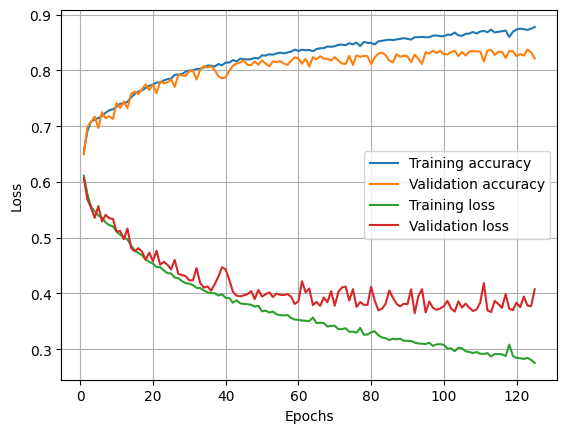

In [31]:
# Plot the training and validation loss and accuracy for each epoch for 1s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
# plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

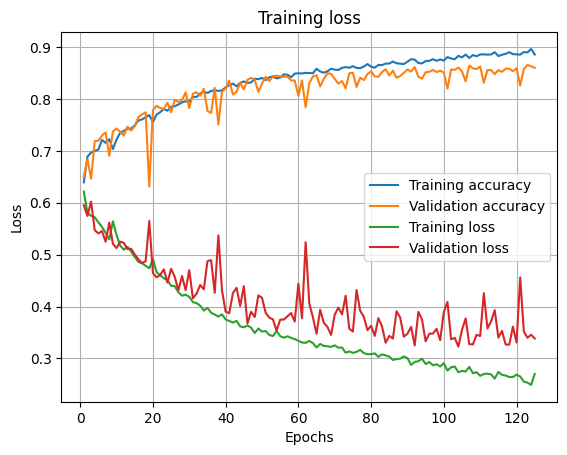

In [10]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Working large model

In [12]:
def block_type1(n_filters1,n_filters2, kernel, pad, x):
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)

    block1_o=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(x)
    block1_o=layers.BatchNormalization()(block1_o)
    added1=layers.add([block1,block1_o])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added1)

def block_type2(n_filters1,n_filters2, kernel, pad, x):
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)

    added=layers.add([x,block])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added)

In [ ]:
def create_model():
  Input=keras.Input(shape=(1024,12),name="Input_signal")
  x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
  y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
  a=layers.add([x,y])
  # x=layers.AveragePooling1D(2)(a)
  x=layers.MaxPooling1D(4)(a)

  x1=block_type1(32,128,3,"same",x)
  x2=block_type2(32,128,13,"same",x1)
  x3=block_type2(32,128,23,"same",x2)
  x3=layers.AveragePooling1D(4)(x3)
  x4=block_type1(64,256,7,"same",x3)
  x5=block_type2(64,256,17,"same",x4)
  x6=block_type2(64,256,27,"same",x5)
  x7=block_type2(64,256,7,"same",x6)
  x16=layers.GlobalAveragePooling1D()(x6)
  x16=layers.Dense(256)(x16)
  x16=layers.Dropout(0.5)(x16)
  x16=layers.Dense(16,activation='swish')(x16)
  x16=layers.Dense(1,activation='sigmoid')(x16)

  model=keras.Model(Input,x16)
  F1 = tfa.metrics.FBetaScore(num_classes=1)
  AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
  AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')

  # used the followiing one to get 0.99 accuracy for 4s data
  # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

  optimizer=keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0002)
  loss=keras.losses.BinaryCrossentropy(from_logits=False)
  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', F1, AUROC, AUPRC])
  
  # keras.utils.plot_model(model,'model.png',show_layer_activations=True,show_shapes=True)
  model.summary()
  return model

model = create_model()


In [19]:
# used 128 as the batch size for 4s data
history=model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=100,batch_size=128)

Epoch 1/100
79/79 [==============================] - 32s 142ms/step - loss: 0.8026 - accuracy: 0.5777 - fbeta_score: 0.7455 - AUROC: 0.5161 - AUPRC: 0.6119 - val_loss: 0.6937 - val_accuracy: 0.5000 - val_fbeta_score: 0.6667 - val_AUROC: 0.4953 - val_AUPRC: 0.4912
Epoch 2/100
79/79 [==============================] - 10s 128ms/step - loss: 0.6427 - accuracy: 0.5941 - fbeta_score: 0.7455 - AUROC: 0.6474 - AUPRC: 0.7442 - val_loss: 0.6806 - val_accuracy: 0.5000 - val_fbeta_score: 0.6667 - val_AUROC: 0.5860 - val_AUPRC: 0.6281
Epoch 3/100
79/79 [==============================] - 10s 130ms/step - loss: 0.5808 - accuracy: 0.6151 - fbeta_score: 0.7455 - AUROC: 0.7447 - AUPRC: 0.8300 - val_loss: 0.6966 - val_accuracy: 0.5437 - val_fbeta_score: 0.6667 - val_AUROC: 0.5307 - val_AUPRC: 0.5357
Epoch 4/100
79/79 [==============================] - 10s 129ms/step - loss: 0.5204 - accuracy: 0.7355 - fbeta_score: 0.7455 - AUROC: 0.8079 - AUPRC: 0.8729 - val_loss: 0.9132 - val_accuracy: 0.6122 - val_fbet

In [21]:
model.save('../BraiNeoCare/models/model1.h5')   

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model=keras.models.load_model('../BraiNeoCare/models/model1.h5')
model.summary()

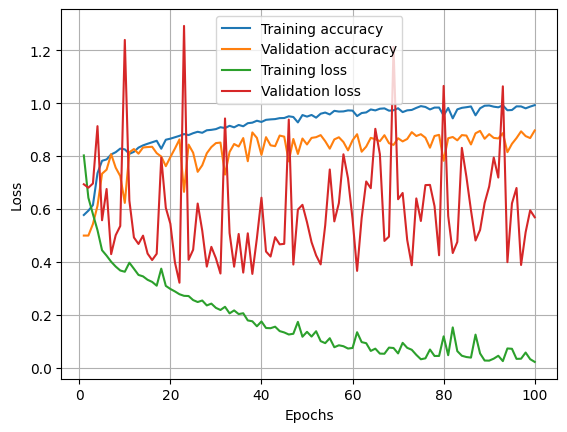

In [28]:
training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(6, 6))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Nima's model

In [ ]:
def create_model():
    i = keras.Input((1024,12), name='signal')
    x = layers.Conv1D(filters=72, kernel_size=15, activation='swish', padding='same')(i)
    a = layers.Conv1D(filters=72, kernel_size=1, padding='same')(i)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=144, kernel_size=3, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=144, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=288, kernel_size=5, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=288, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=576, kernel_size=7, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=576, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    b = layers.SpatialDropout1D(0.2)(a)
    x = layers.GlobalAveragePooling1D()(b)

    # j = keras.Input((2000,2*2), name='fft')
    # y = layers.Conv1D(filters=72, kernel_size=3, activation='swish', padding='same')(j)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=144, kernel_size=5, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=288, kernel_size=7, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=576, kernel_size=9, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=1152, kernel_size=11, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.GlobalAveragePooling1D()(y)

    # f = layers.Concatenate()([x,y])
    # f = layers.Activation('swish')(f)

    f = layers.Dense(576, activation='swish')(x)
    f = layers.Dropout(0.5)(f)
    f = layers.Dense(1,activation = 'sigmoid')(f)

    F1 = tfa.metrics.FBetaScore(num_classes=1)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
    model = keras.Model(i,f)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
    return model

with tpu_strategy.scope():
  model = create_model()


In [ ]:
tf.keras.utils.plot_model(model,'/content/drive/MyDrive/FYP_ML/model_nima.png')

In [ ]:
weight_for_0 = (1 / (tot-pos)) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(train_dataset, validation_data = test_dataset, epochs=100)

## Small model

In [ ]:

# import tensorflow_addons as tfa
# from sklearn.model_selection import train_test_split

model=keras.Sequential(name="BrainNeoCare_CNN")
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu', input_shape=(12,1024),name="Input_conv2D"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_1"))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu',name="Conv2D_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_2"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_3"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_3"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_4"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_1"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',name="2D_F_Con"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_2"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',name="2D_F_Con_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="AveragePooling2D_3"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu') )
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, name="binary_crossentropy",)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_dataset,epochs=10,verbose=1)

## Data manipulation and loading

In [ ]:
x=np.load('/content/drive/MyDrive/FYP_ML/zenodo_data.npy', mmap_mode='r')
y=np.load('/content/drive/MyDrive/FYP_ML/zenodo_labels.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)